# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第3章：動的計画法
* DPをグリッドサーチで解く

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fmin, golden
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

### カリブレーション
* パラメータをひとつの変数にまとめる：classを使う

In [3]:
#カリブレーション
class Params:
    def __init__(self,β,γ,α,δ,nk,kmax,kmin,kgrid,maxit,tol):
        # パラメータ
        self.β = β         # 割引因子
        self.γ = γ         # 相対的危険回避度
        self.α = α         # 資本分配率 
        self.δ = δ         # 固定資本減耗
        
        # グリッド
        self.nk = nk       # 資本のグリッド数
        self.kmax = kmax   # 資本グリッドの最大値
        self.kmin = kmin   # 資本グリッドの最小値
        self.kgrid = kgrid # 資本グリッド

        # 繰り返し計算
        self.maxit = maxit   # 繰り返し計算の最大値
        self.tol = tol     # 計算誤差の許容値(tolerance of error)

In [4]:
def calibration():

    β = 0.96
    γ = 1.0
    α = 0.4
    δ = 1.0 # 0.08

    nk = 10001
    kmax = 0.5 # 固定資本減耗が0.08の場合、ここを10.0にする
    kmin = 0.05

    # numpyで等分グリッドを計算
    kgrid = np.linspace(kmin,kmax,nk)

    maxit = 1000
    tol = 1e-5 # 2.収束の基準を設定

    return Params(β, γ, α, δ, nk, kmax, kmin, kgrid, maxit, tol)

In [5]:
params = calibration();

---

## 経済学でよく使う関数

In [6]:
import MyEconFcn

---

## グリッドサーチのための準備
* 価値関数の初期値はゼロに設定：**当て推量（initial guess）**

In [7]:
# 変数を定義
vfcn = np.zeros(params.nk)
pfcn = np.zeros(params.nk,dtype=int)
Tvfcn = np.zeros(params.nk)
Tpfcn = np.zeros(params.nk,dtype=int)

val_tmp = np.zeros((params.nk,4)) # プロット用の変数
dif = np.zeros((2,params.maxit))   # プロット用の変数

#### すべての状態変数$k$と制御変数$k'$の組み合わせについて効用を計算
* 組み合わせ次第で消費が負値になる可能性がある。そのような値を選択してほしくないので、ペナルティ(=すごく小さな値)を与えて、自発的に選ばないようにする。
* ペナルティの値は任意(モデルによる)なので、**具体的にいくつ位**というのは特にない

In [8]:
# 効用関数の初期値 (消費が0以下になる組み合わせにはペナルティ)
util = -10000.0 * np.ones((params.nk,params.nk))

# 利用可能な最大の資源
wealth = params.kgrid ** params.α + (1-params.δ)*params.kgrid

# 消費が正値になる(k,k')の組み合わせについて効用を計算
for i in range(params.nk): # k
    for j in range(params.nk): # k'
        cons = wealth[i] - params.kgrid[j]
        if cons > 0.0:
            util[j,i] = MyEconFcn.crra(cons,params.γ)

## VFIを実行する
* グリッドサイズが10001の場合、それなりに計算時間がかかるので注意

In [36]:
count = 1

# 最大でmaxit回の繰り返し計算
for it in range(params.maxit):

    vkp = np.zeros((params.nk,params.nk))

    # 4.価値関数の組み合わせを計算
    for i in range(params.nk):
        vkp[:,i] = util[:,i] + params.β*vfcn
    
    # 5.価値観数を最大にする貯蓄を探す

    for i in range(params.nk):

        Tvfcn[i] = np.max(vkp[:,i])
        Tpfcn[i] = np.argmax(vkp[:,i])
    
    # 6.収束しているか確認：繰り返し計算誤差を確認
    dif1 = np.max(np.abs((Tvfcn-vfcn)/vfcn))
    dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn)) 

    #価値関数・政策関数をアップデート
    vfcn = np.copy(Tvfcn)
    pfcn = np.copy(Tpfcn)

    # 収束途中の繰り返し計算誤差を保存
    # 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
    dif[0,it] = dif1
    dif[1,it] = dif2

    # 同じく価値関数の収束を図示する目的で保存(本来は不要)
    if it==1 or it==3 or it==5:
        val_tmp[:,count] = np.copy(vfcn)
        count += 1

    #print(f"iteration counter: {it}")
    #print(f"error(value) : {dif1:.6f}")
    #print(f"error(policy): {dif2:.6f}")

    # 収束したかチェック
    if dif1 < params.tol:
        val_tmp[:,-1] = np.copy(vfcn)
        break

    if it == params.maxit:
        print("The model does not converge")

iteration counter: 0
error(value) : 0.000807
error(policy): 0.000000
iteration counter: 1
error(value) : 0.000774
error(policy): 0.000000
iteration counter: 2
error(value) : 0.000742
error(policy): 0.000000
iteration counter: 3
error(value) : 0.000712
error(policy): 0.000000
iteration counter: 4
error(value) : 0.000683
error(policy): 0.000000
iteration counter: 5
error(value) : 0.000655
error(policy): 0.000000
iteration counter: 6
error(value) : 0.000629
error(policy): 0.000000
iteration counter: 7
error(value) : 0.000603
error(policy): 0.000000
iteration counter: 8
error(value) : 0.000579
error(policy): 0.000000
iteration counter: 9
error(value) : 0.000555
error(policy): 0.000000
iteration counter: 10
error(value) : 0.000533
error(policy): 0.000000
iteration counter: 11
error(value) : 0.000511
error(policy): 0.000000
iteration counter: 12
error(value) : 0.000491
error(policy): 0.000000
iteration counter: 13
error(value) : 0.000471
error(policy): 0.000000
iteration counter: 14
error(va

---

In [9]:
def ddp(params):
    """
    ------------------------------------------------------------------
    === 状態変数と操作変数を離散化して動的計画法(discretized DP)を解く ===
    ------------------------------------------------------------------
    <input>
    ・params: パラメータを含む構造体
    <output>
    ・vfcn: 価値関数
    ・pfcn: 政策関数
    ・dif: 価値関数と政策関数の繰り返し計算誤差
    ・val_tmp: 価値関数の図示の際に利用
    """
    
    count = 0 # 価値関数の図示の際に利用

    # 価値関数・政策関数の初期値を設定
    vfcn = np.zeros(params.nk)
    pfcn = np.zeros(params.nk,dtype=int)
    Tvfcn = np.zeros(params.nk)
    Tpfcn = np.zeros(params.nk,dtype=int)

    val_tmp = np.zeros((params.nk,4))  # プロット用の変数
    dif = np.zeros((2,params.maxit))   # プロット用の変数

    # 効用関数の組み合わせ
    # 効用関数の初期値 (消費が0以下になる組み合わせにはペナルティ)
    util = -10000.0 * np.ones((params.nk,params.nk))

    # 利用可能な最大の資源
    wealth = params.kgrid ** params.α + (1-params.δ)*params.kgrid

    # 消費が正値になる(k,k')の組み合わせについて効用を計算
    for i in range(params.nk): # k
        for j in range(params.nk): # k'
            cons = wealth[i] - params.kgrid[j]
            if cons > 0.0:
                util[j,i] = MyEconFcn.crra(cons,params.γ)
    
    # VFIのメインパート
    for it in range(params.maxit):

        vkp = np.zeros((params.nk,params.nk))

        for i in range(params.nk):
            vkp[:,i] = util[:,i] + params.β*vfcn
    
        for i in range(params.nk):

            Tvfcn[i] = np.max(vkp[:,i])
            Tpfcn[i] = np.argmax(vkp[:,i])
    
        # 繰り返し計算誤差を確認
        dif1 = np.max(np.abs((Tvfcn-vfcn)/vfcn))
        dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn)) 

        # 価値関数・政策関数をアップデート
        vfcn = np.copy(Tvfcn)
        pfcn = np.copy(Tpfcn)

        # 収束途中の繰り返し計算誤差を保存
        # 途中経過を図示する目的なので、通常は不要(むしろ遅くなるので消すべき)
        dif[0,it] = dif1
        dif[1,it] = dif2

        # 同じく価値関数の収束を図示する目的で保存(本来は不要)
        if it==1 or it==3 or it==5:
            val_tmp[:,count] = np.copy(vfcn)
            count += 1

        print(f"iteration counter: {it}")
        print(f"error(value) : {dif1:.6f}")
        print(f"error(policy): {dif2:.6f}")
        print(" ")

        # 収束したかチェック
        if dif1 < params.tol:
            val_tmp[:,-1] = np.copy(vfcn)
            break

        if it == params.maxit:
            print("The model does not converge")
    
    return vfcn, pfcn, dif, val_tmp

In [10]:
start = time.time()
vfcn, pfcn, dif, val_tmp = ddp(params)
end = time.time()
print(f"{end-start:.6f} seconds") 

C:\Users\sakan\AppData\Local\Temp\ipykernel_19556\1233796752.py:54: RuntimeWarning: divide by zero encountered in true_divide
  dif1 = np.max(np.abs((Tvfcn-vfcn)/vfcn))
C:\Users\sakan\AppData\Local\Temp\ipykernel_19556\1233796752.py:55: RuntimeWarning: invalid value encountered in true_divide
  dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn))


iteration counter: 0
error(value) : inf
error(policy): nan
 


C:\Users\sakan\AppData\Local\Temp\ipykernel_19556\1233796752.py:55: RuntimeWarning: divide by zero encountered in true_divide
  dif2 = np.max(np.abs((Tpfcn-pfcn)/pfcn))


iteration counter: 1
error(value) : 2.744248
error(policy): inf
 
iteration counter: 2
error(value) : 0.775316
error(policy): 0.349628
 
iteration counter: 3
error(value) : 0.431593
error(policy): 0.095201
 
iteration counter: 4
error(value) : 0.292467
error(policy): 0.032951
 
iteration counter: 5
error(value) : 0.218113
error(policy): 0.012544
 
iteration counter: 6
error(value) : 0.172169
error(policy): 0.005019
 
iteration counter: 7
error(value) : 0.141095
error(policy): 0.002099
 
iteration counter: 8
error(value) : 0.118733
error(policy): 0.001344
 
iteration counter: 9
error(value) : 0.101896
error(policy): 0.000682
 
iteration counter: 10
error(value) : 0.088778
error(policy): 0.000679
 
iteration counter: 11
error(value) : 0.078279
error(policy): 0.000679
 
iteration counter: 12
error(value) : 0.069693
error(policy): 0.000657
 
iteration counter: 13
error(value) : 0.062546
error(policy): 0.000678
 
iteration counter: 14
error(value) : 0.056510
error(policy): 0.000510
 
iterat

#### ⬆で計算した政策関数は最大値の**位置**なので、政策関数の**値**に変換

In [11]:
policy = np.zeros(params.nk)
for i in range(params.nk):
    policy[i] = params.kgrid[pfcn[i]]


In [12]:
# 政策関数を使って収束した価値関数を計算
util = np.zeros(params.nk)
valfn = np.zeros(params.nk)

for i in range(params.nk):
    cons = params.kgrid[i]**params.α + (1-params.δ)*params.kgrid[i] - policy[i]
    util[i] = MyEconFcn.crra(cons, params.γ)
    valfn[i] = util[i] / (1-params.β)

---

In [13]:
# 解析解
AA = (1-params.β)**(-1) * (np.log(1-params.α*params.β) + ((params.α*params.β)/(1-params.α*params.β))*np.log(params.α*params.β))
BB = params.α / (1 - params.α*params.β)
v_true = AA + BB*np.log(params.kgrid)
p_true = params.α*params.β*(params.kgrid ** params.α);

---

# プロット

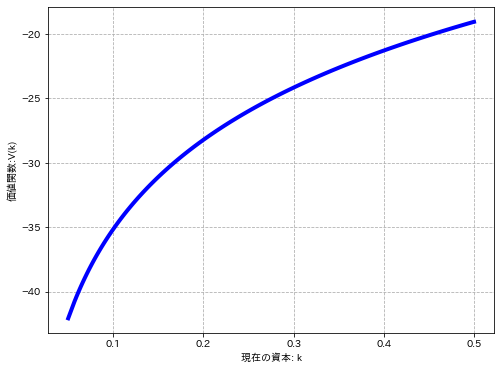

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,valfn,c="b",lw=4)
ax.set(xlabel="現在の資本: k", ylabel="価値関数:V(k)")
ax.grid(ls="--")
plt.show()

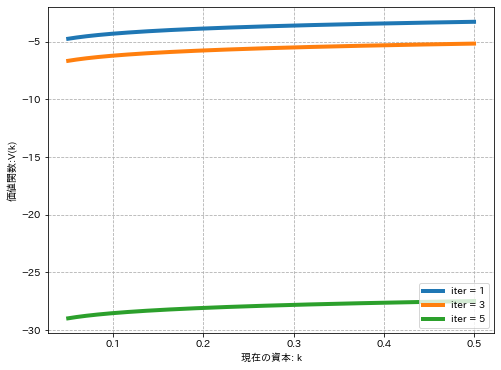

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,val_tmp[:,1],lw=4,label="iter = 1")
ax.plot(params.kgrid,val_tmp[:,2],lw=4,label="iter = 3")
ax.plot(params.kgrid,val_tmp[:,3],lw=4,label="iter = 5")
ax.set(xlabel="現在の資本: k", ylabel="価値関数:V(k)")
ax.legend(loc="lower right")
ax.grid(ls="--")
plt.show()

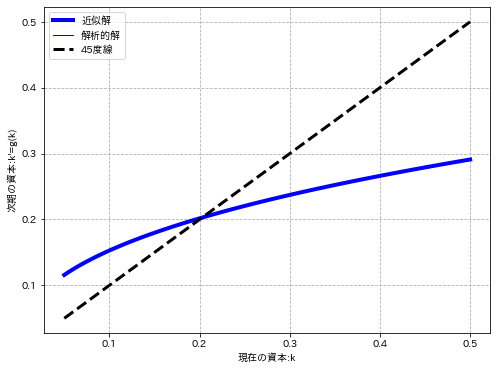

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.kgrid,policy,c="b",lw=4,label="近似解")
ax.plot(params.kgrid,p_true,c="b",lw=1,label="解析的解")
ax.plot(params.kgrid,params.kgrid,ls="--",c="k",lw=3,label="45度線")
ax.set(xlabel="現在の資本:k",ylabel="次期の資本:k'=g(k)")
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()

In [43]:
dif.shape

(2, 1000)

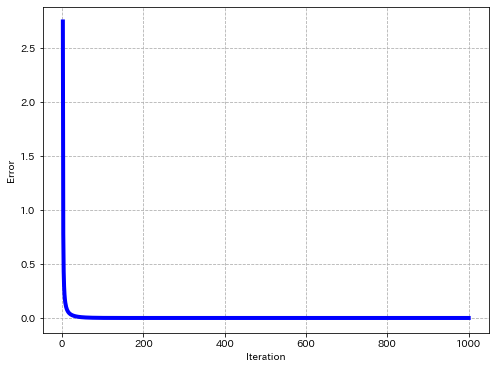

In [17]:
time = range(1,params.maxit+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time,dif[0,:],c="b",lw=4)
ax.set(xlabel="Iteration",ylabel="Error")
ax.grid(ls="--")
plt.show()

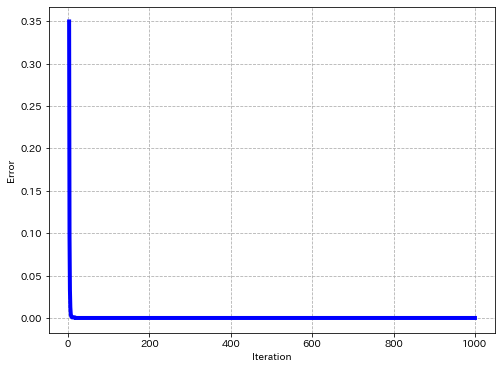

In [18]:
time = range(1,params.maxit+1)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time,dif[1,:],c="b",lw=4)
ax.set(xlabel="Iteration",ylabel="Error")
ax.grid(ls="--")
plt.show()

---

# エクササイズ
* グリッドサイズを増やしたら、どの位計算速度が劣化するかを確認してみよう。
* モデルを拡張して、所得リスクを導入してみよう。
* 収束の基準に価値関数の繰り返し計算誤差ではなく、政策関数の繰り返し計算誤差を使ったらどうなるかを確認してみよう。